## CHAYA_62M — Context-aware Hybrid Autoregressive Transformer Architecture

**Phase 2 Training** on SWIFT-700 Dataset

This notebook implements Phase 2 continued training from Phase 1 checkpoint:

- **Phase 1:** 678M tokens (6 epochs on WikiText-103)
- **Phase 2:** 700M tokens (1 epoch on SWIFT-700)
- **Total Training:** 1.378B tokens

**SWIFT-700 Dataset Composition:**
- OpenWebText (35%) - General knowledge, diverse topics
- TinyStories (25%) - Narrative coherence, context flow
- FineWeb-Edu (19%) - Educational content
- ArXiv Papers (10%) - Scientific reasoning
- WikiText-103 (9%) - Factual knowledge
- QA Datasets (1%) - Instruction following

**Training Configuration:**
- D_MODEL = 640, E_DIM = 192, 8 layers, 8 heads
- SEQ_LEN = 256, BATCH_SIZE = 40
- LR = 8e-5 (reduced from Phase 1's 1.9e-4)
- 1 epoch with validation every 0.25 epoch
- ~62M trainable parameters


## Imports

In [1]:
import os
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2TokenizerFast
from datasets import load_dataset
from torchinfo import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
torch.backends.cudnn.benchmark = True

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# GPT-2 Tokenizer

In [3]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
vocab_size = tokenizer.vocab_size
print("Loaded GPT-2 tokenizer. Vocab size:", vocab_size)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loaded GPT-2 tokenizer. Vocab size: 50257


# Dataset loading and Tokenization

In [6]:

# --------------------------------SWIFT-700 Dataset Loading-------------------------------- #


SHARD_DIR = "/kaggle/input/datasets/pranoy72/swift-700m/SWIFT_tokens" 
SEQ_LEN=256
BATCH_SIZE=40
class ShardedTokenDataset(Dataset):
    def __init__(self, shard_dir, seq_len=256, split="train"):
        self.shard_dir = shard_dir
        self.seq_len = seq_len
        self.split = split
        
        if split == "train":
            self.shard_files = sorted([
                os.path.join(shard_dir, f) 
                for f in os.listdir(shard_dir) 
                if f.startswith("SWIFT_train_shard_") and f.endswith(".pt")
            ])
        else:
            self.shard_files = sorted([
                os.path.join(shard_dir, f) 
                for f in os.listdir(shard_dir) 
                if f.startswith("SWIFT_val_shard_") and f.endswith(".pt")
            ])
        
        if not self.shard_files:
            raise ValueError(f"No {split} shards found in {shard_dir}")
        
        print(f"Found {len(self.shard_files)} {split} shards")
        
        print(f"Loading {split} shards into memory...")
        self.tokens = []
        for shard_file in self.shard_files:
            shard = torch.load(shard_file)
            self.tokens.extend(shard.tolist())
        
        self.tokens = torch.tensor(self.tokens, dtype=torch.long)
        self.num_sequences = (len(self.tokens) - 1) // seq_len
        
        print(f"✓ Loaded {len(self.tokens):,} tokens for {split}")
        print(f"✓ Created {self.num_sequences:,} sequences of length {seq_len}")
    
    def __len__(self):
        return self.num_sequences
    
    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        x = self.tokens[start_idx:start_idx + self.seq_len]
        y = self.tokens[start_idx + 1:start_idx + self.seq_len + 1]
        return x, y

print("="*80)
print("LOADING SWIFT-700 DATASET")
print("="*80)

train_dataset = ShardedTokenDataset(SHARD_DIR, seq_len=SEQ_LEN, split="train")
val_dataset = ShardedTokenDataset(SHARD_DIR, seq_len=SEQ_LEN, split="val")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("\n" + "="*80)
print("DATASET READY")
print("="*80)
print(f"Train sequences: {len(train_dataset):,}")
print(f"Val sequences: {len(val_dataset):,}")
print(f"Train batches: {len(train_loader):,}")
print(f"Val batches: {len(val_loader):,}")
print(f"Batch size: {BATCH_SIZE}")
print("="*80)

x_test, y_test = next(iter(train_loader))
print(f"\n✓ Test batch: x={x_test.shape}, y={y_test.shape}")
print(f"✓ Dataset ready for training!\n")

# --------------------------------SWIFT-700 Dataset Loading-------------------------------- #


LOADING SWIFT-700 DATASET
Found 70 train shards
Loading train shards into memory...


KeyboardInterrupt: 

# Dataset loading and Tokenization (Memory-Efficient Shard Loader) <loads one shard at a time>

In [4]:

class StreamingShardDataset(IterableDataset):
    """
    Memory-efficient dataset that loads shards one at a time.
    Use this if loading all shards into memory causes OOM errors.
    """
    def __init__(self, shard_dir, seq_len=256, split="train"):
        self.shard_dir = shard_dir
        self.seq_len = seq_len
        self.split = split
        
        # Find shard files
        if split == "train":
            self.shard_files = sorted([
                os.path.join(shard_dir, f) 
                for f in os.listdir(shard_dir) 
                if f.startswith("SWIFT_train_shard_") and f.endswith(".pt")
            ])
        else:
            self.shard_files = sorted([
                os.path.join(shard_dir, f) 
                for f in os.listdir(shard_dir) 
                if f.startswith("SWIFT_val_shard_") and f.endswith(".pt")
            ])
        
        print(f"Found {len(self.shard_files)} {split} shards")
        
        if not self.shard_files:
            raise ValueError(f"No {split} shards found in {shard_dir}")
    
    def __iter__(self):
        # Shuffle shard order for training
        shard_files = self.shard_files.copy()
        if self.split == "train":
            random.shuffle(shard_files)
        
        # Process each shard
        for shard_file in shard_files:
            # Load one shard at a time
            tokens = torch.load(shard_file)

            tokens = tokens.long()
            # Generate sequences from this shard
            num_sequences = (len(tokens) - 1) // self.seq_len
            
            for i in range(num_sequences):
                start_idx = i * self.seq_len
                x = tokens[start_idx:start_idx + self.seq_len]
                y = tokens[start_idx + 1:start_idx + self.seq_len + 1]
                yield x, y



SHARD_DIR = "/kaggle/input/datasets/pranoy72/swift-700m/SWIFT_tokens"
SEQ_LEN = 256
BATCH_SIZE = 40

print("="*80)
print("LOADING DATASET (MEMORY-EFFICIENT MODE)")
print("="*80 + "\n")

train_dataset = StreamingShardDataset(SHARD_DIR, seq_len=SEQ_LEN, split="train")
val_dataset = StreamingShardDataset(SHARD_DIR, seq_len=SEQ_LEN, split="val")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0  # Must be 0 for IterableDataset
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0
)

print("✓ Dataset ready (streaming mode)")
print("✓ Loads one shard at a time to save memory")

# Test
x, y = next(iter(train_loader))
print(f"\n✓ Test batch: x={x.shape}, y={y.shape}")

LOADING DATASET (MEMORY-EFFICIENT MODE)

Found 70 train shards
Found 1 val shards
✓ Dataset ready (streaming mode)
✓ Loads one shard at a time to save memory

✓ Test batch: x=torch.Size([40, 256]), y=torch.Size([40, 256])


## Model Architecture

In [5]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization (no mean subtraction)."""
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)        
        x_normed = x / rms
        return self.scale * x_normed

class RotaryEmbedding(nn.Module):
    """Precompute inverse frequencies for RoPE and provide cos/sin for a sequence length."""
    def __init__(self, dim):
        super().__init__()
        assert dim % 2 == 0, "RoPE head dim must be even"
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))        
        self.register_buffer("inv_freq", inv_freq)

    def get_cos_sin(self, seq_len, device, dtype=torch.float32):
        t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)        
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)        
        emb = torch.cat((freqs, freqs), dim=-1)        
        cos = emb.cos().to(dtype)[None, None, :, :]        
        sin = emb.sin().to(dtype)[None, None, :, :]        
        return cos, sin

def apply_rope(q, k, cos, sin):
    """
    q, k : (B, heads, T, head_dim)
    cos/sin: (1,1,T,head_dim)
    Returns rotated q,k with RoPE applied.
    """
    def rotate_half(x):
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        return torch.cat((-x2, x1), dim=-1)    
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.scale = math.sqrt(self.head_dim)

        self.qkv = nn.Linear(d_model, d_model * 3, bias=False)
        self.out = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.rotary = RotaryEmbedding(self.head_dim)

    def forward(self, x):
        B, T, C = x.size()
        qkv = self.qkv(x)        
        q, k, v = qkv.chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        cos, sin = self.rotary.get_cos_sin(T, x.device, dtype=q.dtype)        
        q, k = apply_rope(q, k, cos, sin)

        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        mask = torch.tril(torch.ones((T, T), device=x.device, dtype=torch.bool)).unsqueeze(0).unsqueeze(0)        
        scores = scores.masked_fill(~mask, float("-inf"))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)        
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, C)        
        return self.out(out)

class SwiGLU(nn.Module):
    """
    SwiGLU variant:
      out = W3( SiLU(W1(x)) * W2(x) )
    This is a gated linear unit with SiLU nonlinearity; effective and parameter-efficient.
    """
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, dim, bias=False)

    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_mult=4, dropout=0.1):
        super().__init__()
        hidden_dim = int(d_model * ff_mult)

        self.norm1 = RMSNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, num_heads, dropout=dropout)

        self.norm2 = RMSNorm(d_model)
        self.ffn = SwiGLU(d_model, hidden_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x


## Building & Instantiating the model

In [ ]:
E_DIM = 192        
D_MODEL = 640
NUM_LAYERS = 8
NUM_HEADS = 8     
FF_MULT = 4
LR = 0.00008
WEIGHT_DECAY = 1e-2
CLIP_GRAD = 1.0
DROPOUT = 0.05


class CHAYA_62M(nn.Module):    

    def __init__(        
        self,        
        vocab_size,        
        e_dim=E_DIM,        
        d_model=D_MODEL,        
        num_heads=NUM_HEADS,        
        num_layers=NUM_LAYERS,        
        seq_len=SEQ_LEN,        
        dropout=DROPOUT,        
        ff_mult=FF_MULT    
    ):
        super().__init__()

        self.vocab_size = vocab_size        
        self.e_dim = e_dim        
        self.d_model = d_model        
        self.seq_len = seq_len        

        self.token_embedding = nn.Embedding(vocab_size, e_dim)        
        self.emb_proj = nn.Linear(e_dim, d_model, bias=False)        

        self.layers = nn.ModuleList([
            TransformerBlock(
                d_model=d_model,
                num_heads=num_heads,
                ff_mult=ff_mult,
                dropout=dropout
            )
            for _ in range(num_layers)
        ])

        self.norm_f = RMSNorm(d_model)        
        self.out_proj = nn.Linear(d_model, e_dim, bias=False)    

    def forward(self, idx):        
        emb_e = self.token_embedding(idx)                
        x = self.emb_proj(emb_e)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)        
        e_logits = self.out_proj(x)                
        logits = e_logits @ self.token_embedding.weight.t()

        return logits


# -----------------------------------Instantiating a new model with random weight------------------------------------- #
 #Instantiating the model
model = CHAYA_62M(
     vocab_size=vocab_size,
     e_dim=E_DIM,
     d_model=D_MODEL,
     num_heads=NUM_HEADS,
     num_layers=NUM_LAYERS,
     seq_len=SEQ_LEN,
     dropout=DROPOUT
 ).to(device)

print("Model instantiated")
# -----------------------------------Instantiating a new model with random weight------------------------------------- #


# -------------------------------Loading fully saved model <not checkpoint model>------------------------------------- #

# ckpt = torch.load("/kaggle/input/---", map_location=device)

#model = CHAYA_62M(
#    vocab_size=ckpt["vocab_size"],
#    e_dim=ckpt["e_dim"],
#    d_model=ckpt["d_model"],
#    num_heads=ckpt["num_heads"],
#    num_layers=ckpt["num_layers"],
#    seq_len=ckpt["seq_len"]
#).to(device)
#
# state_dict = ckpt["model_state_dict"]

# # ----------- FIX: Remove DataParallel "module." prefix if present -----------
# if list(state_dict.keys())[0].startswith("module."):
#     state_dict = {k[7:]: v for k, v in state_dict.items()}
# # ---------------------------------------------------------------------------

# model.load_state_dict(state_dict)

# print("✓ Previously trained model loaded successfully")


# -------------------------------Loading fully saved model <not checkpoint model>------------------------------------- #


# --------------------------------For loading the checkpoint model----------------------------------------------------- #
#        |                                                                                           |
#        |                                                                                           |
# -------|------1--< Instantiate a new model with random weight >------------------------------------|------------ #
#        |                                                                                           |
# -------|------2--< The checkpoint model will be loaded in the training loop section >--------------|------------ #
#        |                                                                                           |
# -------|---------< Checkpoint Loading Function to be specific >------------------------------------|------------ #
#        |                                                                                           |
#        |                                                                                           |
# --------------------------------For loading the checkpoint model------------------------------------------------------ #


Model instantiated


## model summary

In [10]:
dummy_input = torch.zeros((BATCH_SIZE, SEQ_LEN), dtype=torch.long).to(device)
summary(model, input_data=dummy_input)



Layer (type:depth-idx)                        Output Shape              Param #
CHAYA_62M                                     [40, 256, 50257]          --
├─Embedding: 1-1                              [40, 256, 192]            9,649,344
├─Linear: 1-2                                 [40, 256, 640]            122,880
├─ModuleList: 1-3                             --                        --
│    └─TransformerBlock: 2-1                  [40, 256, 640]            --
│    │    └─RMSNorm: 3-1                      [40, 256, 640]            640
│    │    └─MultiHeadSelfAttention: 3-2       [40, 256, 640]            1,638,400
│    │    └─Dropout: 3-3                      [40, 256, 640]            --
│    │    └─RMSNorm: 3-4                      [40, 256, 640]            640
│    │    └─SwiGLU: 3-5                       [40, 256, 640]            4,915,200
│    │    └─Dropout: 3-6                      [40, 256, 640]            --
│    └─TransformerBlock: 2-2                  [40, 256, 640]       

In [14]:
if hasattr(model, "module"):
    real_model = model.module
else:
    real_model = model

total_params = sum(p.numel() for p in real_model.parameters())
print("Total parameters:", total_params / 1e6, "Million")


Total parameters: 62.334784 Million


## Training optimizations & train val loop

In [7]:
EPOCHS = 1



# -----------------------------------------optimizer---------------------------------------- #
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# -----------------------------------------optimizer---------------------------------------- #


# --------------------------------------warmup scheduler------------------------------------ #
class WarmupLinearScheduler:
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr):
        self.optimizer = optimizer
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(1, total_steps)
        self.base_lr = base_lr
        self.step_num = 0

    def step(self):
        self.step_num += 1

        if self.step_num < self.warmup_steps:
            lr_scale = self.step_num / self.warmup_steps
        else:
            progress = (self.step_num - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            lr_scale = max(0.0, 1.0 - progress)

        lr = self.base_lr * lr_scale
        for g in self.optimizer.param_groups:
            g["lr"] = lr

#total_steps = max(1, len(train_loader) * EPOCHS)

TRAIN_TOKEN_SWIFT= 693085198  # SWIFT-700 total token count (from train)
tokens_per_step = SEQ_LEN * BATCH_SIZE
steps_per_epoch = TRAIN_TOKEN_SWIFT // tokens_per_step
total_steps = steps_per_epoch * EPOCHS

warmup_steps = 2000
scheduler = WarmupLinearScheduler(
    optimizer,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    base_lr=LR
)

scaler = torch.cuda.amp.GradScaler()
# --------------------------------------warmup scheduler------------------------------------ #


# --------------------------------------Metrics helpers------------------------------------- #
def token_accuracy(logits, targets):
    preds = logits.argmax(dim=-1)
    correct = (preds == targets).float().sum().item()
    total = targets.numel()
    return correct / total

def perplexity_from_loss(loss):
    try:
        return math.exp(loss)
    except OverflowError:
        return float('inf')
# --------------------------------------Metrics helpers------------------------------------- #


# -------------------------------------Train & val loop------------------------------------- #

def train_epoch(model, loader, optimizer, criterion, scheduler=None, scaler=None, clip_grad=1.0):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    pbar = tqdm(loader, desc="Training", leave=False)
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        scaler.step(optimizer)
        scaler.update()

        if scheduler:
            scheduler.step()
            if scheduler.step_num % 1000 == 0:
                print("LR:", optimizer.param_groups[0]["lr"])

        acc = token_accuracy(logits, y)
        total_loss += loss.item()
        total_acc += acc

        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{acc:.4f}",
            ppl=f"{perplexity_from_loss(loss.item()):.4f}"
        )


    return total_loss / len(loader), total_acc / len(loader)


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    batch_count = 0
    
    pbar = tqdm(loader, desc="Validation", total=total_val_batches)
    with torch.no_grad():
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            acc = token_accuracy(logits, y)
            total_loss += loss.item()
            total_acc += acc
            batch_count += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")
    
    return total_loss / batch_count, total_acc / batch_count
# -------------------------------------Train & val loop------------------------------------- #



/tmp/ipykernel_55/372134745.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Training loop

In [ ]:
phase1_path = "/kaggle/input/----"
save_path = "chaya_62m_phase2_checkpoint.pt" 
best_val_path = "chaya_62m_phase2_best.pt"
best_val = float("inf")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# ------------------------------Checkpoint Loading Function------------------------------- #
def load_checkpoint(model, optimizer, scheduler, scaler, resume_path=save_path, phase1_path=phase1_path):
    # Try to load Phase 2 resume checkpoint first
    if os.path.exists(resume_path):
        print(f"Found Phase 2 checkpoint: {resume_path}")
        checkpoint = torch.load(resume_path, map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"]
        model.load_state_dict(state_dict)

        if "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        if "scheduler_state_dict" in checkpoint:
            scheduler.__dict__.update(checkpoint["scheduler_state_dict"])
        if "scaler_state_dict" in checkpoint:
            scaler.load_state_dict(checkpoint["scaler_state_dict"])

        start_epoch = checkpoint.get("epoch", 0)
        best = checkpoint.get("best_val", float("inf"))
        
        print(f"✓ Resumed Phase 2 from checkpoint: epoch {start_epoch}, best val: {best:.4f}")
        return start_epoch, best, model
    
    # Otherwise load Phase 1 checkpoint (fresh start for Phase 2)
    else:
        print(f"No Phase 2 checkpoint found. Loading Phase 1 model from: {phase1_path}")
        checkpoint = torch.load(phase1_path, map_location=device, weights_only=False)
        state_dict = checkpoint["model_state_dict"]
        model.load_state_dict(state_dict)
        
        print(f"✓ Loaded Phase 1 model. Starting Phase 2 from epoch 0")
        return 0, float("inf"), model
# ------------------------------Checkpoint Loading Function------------------------------- #


start_epoch, best_val, model = load_checkpoint(model, optimizer, scheduler, scaler)

# --------------------------------Multi-GPU Setup-------------------------------------- #
if torch.cuda.device_count() > 1:
    print(f"\n{'='*80}")
    print(f"MULTI-GPU DETECTED: Using {torch.cuda.device_count()} GPUs")
    print(f"{'='*80}")
    model = torch.nn.DataParallel(model)
    print(f"✓ Model wrapped with DataParallel")
    print(f"{'='*80}\n")
else:
    print(f"\nUsing single GPU: {torch.cuda.get_device_name(0)}\n")
# --------------------------------Multi-GPU Setup-------------------------------------- #


# -------------------------Calculate total batches (for streaming)------------------------- #
TOTAL_TRAIN_TOKENS = 693_085_198
TOTAL_VAL_TOKENS = 7_000_000
SEQ_LEN = 256
BATCH_SIZE = 40

train_sequences = TOTAL_TRAIN_TOKENS // SEQ_LEN
val_sequences = TOTAL_VAL_TOKENS // SEQ_LEN
total_train_batches = train_sequences // BATCH_SIZE
total_val_batches = val_sequences // BATCH_SIZE

print("="*80)
print("STARTING PHASE 2 TRAINING")
print("="*80)
print(f"Epochs: {EPOCHS}")
print(f"Validation every 0.25 epoch (4 times total)")
print(f"Estimated batches per epoch: {total_train_batches:,}")
print(f"Total steps: {total_train_batches * EPOCHS:,}")
print(f"Learning rate: {LR}")
print("="*80 + "\n")

batches_per_quarter = total_train_batches // 4
# -------------------------Calculate total batches (for streaming)------------------------- #


# --------------------------------Phase 2 Training Loop------------------------------------ #
for epoch in range(start_epoch + 1, EPOCHS + 1):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch}/{EPOCHS}")
    print(f"{'='*80}")
    
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    quarter_loss, quarter_acc = 0.0, 0.0
    quarter_batches = 0
    batch_count = 0
    
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", total=total_train_batches)
    
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        scaler.step(optimizer)
        scaler.update()

        if scheduler:
            scheduler.step()

        acc = token_accuracy(logits, y)
        epoch_loss += loss.item()
        epoch_acc += acc
        quarter_loss += loss.item()
        quarter_acc += acc
        quarter_batches += 1
        batch_count += 1

        pbar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{acc:.4f}",
            ppl=f"{perplexity_from_loss(loss.item()):.4f}",
            lr=f"{optimizer.param_groups[0]['lr']:.2e}"
        )
        
        if batch_count % batches_per_quarter == 0 or batch_count == total_train_batches:
            quarter_num = batch_count // batches_per_quarter
            if quarter_num > 4:
                quarter_num = 4
            
            avg_quarter_loss = quarter_loss / quarter_batches
            avg_quarter_acc = quarter_acc / quarter_batches
            
            print(f"\n{'='*80}")
            print(f"VALIDATION @ Epoch {epoch} - {quarter_num * 25}% ({batch_count}/{total_train_batches} batches)")
            print(f"{'='*80}")
            print(f"Training - Loss: {avg_quarter_loss:.4f}, Acc: {avg_quarter_acc:.4f}, PPL: {perplexity_from_loss(avg_quarter_loss):.4f}")
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            val_ppl = perplexity_from_loss(val_loss)
            
            print(f"Validation - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, PPL: {val_ppl:.4f}")
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            checkpoint_path = f"chaya_62m_phase2_epoch{epoch}_q{quarter_num}.pt"
            torch.save({
                "model_state_dict": model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.__dict__,
                "scaler_state_dict": scaler.state_dict(),
                "epoch": epoch,
                "quarter": quarter_num,
                "batch_count": batch_count,
                "best_val": best_val,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "train_loss": avg_quarter_loss,
                "train_acc": avg_quarter_acc
            }, checkpoint_path)
            print(f"✓ Saved checkpoint: {checkpoint_path}")
            
            if val_loss < best_val:
                best_val = val_loss
                torch.save({
                    "model_state_dict": model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "epoch": epoch,
                    "quarter": quarter_num,
                    "best_val": best_val,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "vocab_size": vocab_size,
                    "e_dim": E_DIM,
                    "d_model": D_MODEL,
                    "num_layers": NUM_LAYERS,
                    "num_heads": NUM_HEADS,
                    "seq_len": SEQ_LEN
                }, best_val_path)
                print(f"✓ NEW BEST MODEL! Saved to {best_val_path}")
            
            print(f"{'='*80}\n")
            
            quarter_loss, quarter_acc = 0.0, 0.0
            quarter_batches = 0
            model.train()
    
    avg_train_loss = epoch_loss / batch_count
    avg_train_acc = epoch_acc / batch_count
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch} COMPLETE")
    print(f"{'='*80}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")
    print(f"Best Val Loss: {best_val:.4f}")
    print(f"{'='*80}\n")
# --------------------------------Phase 2 Training Loop------------------------------------ #


print("\n" + "="*80)
print("PHASE 2 TRAINING COMPLETE")
print("="*80)
print(f"Best Validation Loss: {best_val:.4f}")
print(f"Best Validation PPL: {perplexity_from_loss(best_val):.4f}")
print(f"Best model saved: {best_val_path}")
print("="*80)

No Phase 2 checkpoint found. Loading Phase 1 model from: /kaggle/input/models/pranoy72/chaya-62m-phase1/pytorch/phase-1/1/minigpt_bpe_v3_E6.pt
✓ Loaded Phase 1 model. Starting Phase 2 from epoch 0

MULTI-GPU DETECTED: Using 2 GPUs
✓ Model wrapped with DataParallel

STARTING PHASE 2 TRAINING
Epochs: 1
Validation every 0.25 epoch (4 times total)
Estimated batches per epoch: 67,684
Total steps: 67,684
Learning rate: 8e-05


EPOCH 1/1


Training Epoch 1:   0%|          | 0/67684 [00:00<?, ?it/s]

/tmp/ipykernel_55/2388677070.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



VALIDATION @ Epoch 1 - 25% (16921/67684 batches)
Training - Loss: 4.1925, Acc: 0.3507, PPL: 66.1899


Validation:   0%|          | 0/683 [00:00<?, ?it/s]

Validation - Loss: 3.8763, Acc: 0.3736, PPL: 48.2441
✓ Saved checkpoint: chaya_62m_phase2_epoch1_q1.pt
✓ NEW BEST MODEL! Saved to chaya_62m_phase2_best.pt


VALIDATION @ Epoch 1 - 50% (33842/67684 batches)
Training - Loss: 3.8568, Acc: 0.3730, PPL: 47.3143


Validation:   0%|          | 0/683 [00:00<?, ?it/s]

Validation - Loss: 3.7669, Acc: 0.3848, PPL: 43.2439
✓ Saved checkpoint: chaya_62m_phase2_epoch1_q2.pt
✓ NEW BEST MODEL! Saved to chaya_62m_phase2_best.pt


VALIDATION @ Epoch 1 - 75% (50763/67684 batches)
Training - Loss: 3.5148, Acc: 0.4070, PPL: 33.6102


Validation:   0%|          | 0/683 [00:00<?, ?it/s]

Validation - Loss: 3.6668, Acc: 0.3942, PPL: 39.1269
✓ Saved checkpoint: chaya_62m_phase2_epoch1_q3.pt
✓ NEW BEST MODEL! Saved to chaya_62m_phase2_best.pt


VALIDATION @ Epoch 1 - 100% (67684/67684 batches)
Training - Loss: 3.8457, Acc: 0.3755, PPL: 46.7893


Validation:   0%|          | 0/683 [00:00<?, ?it/s]

Validation - Loss: 3.6347, Acc: 0.3978, PPL: 37.8896
✓ Saved checkpoint: chaya_62m_phase2_epoch1_q4.pt
✓ NEW BEST MODEL! Saved to chaya_62m_phase2_best.pt


EPOCH 1 COMPLETE
Train Loss: 3.8525, Train Acc: 0.3765
Best Val Loss: 3.6347


PHASE 2 TRAINING COMPLETE
Best Validation Loss: 3.6347
Best Validation PPL: 37.8896
Best model saved: chaya_62m_phase2_best.pt


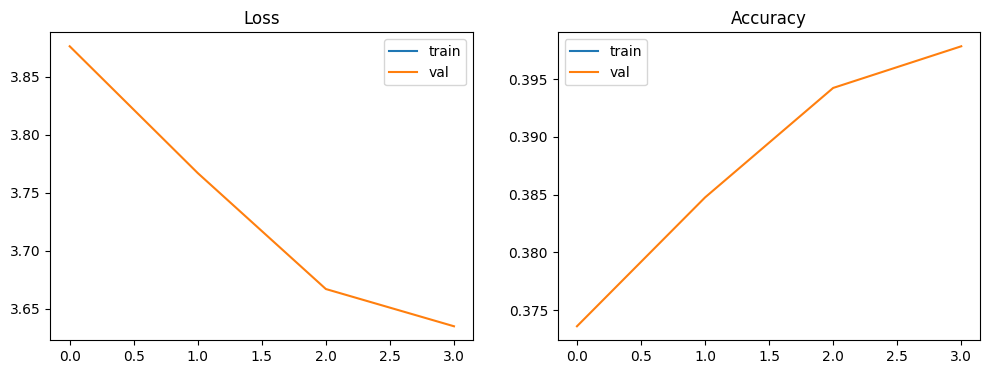

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.legend(); plt.title("Accuracy")

plt.show()


## Inference

In [12]:
def top_k_logits(logits, k=None):
    if k is None:
        return logits
    v, _ = torch.topk(logits, k)
    min_v = v[:, -1].unsqueeze(1)
    return torch.where(logits < min_v, torch.full_like(logits, -1e10), logits)

@torch.no_grad()
def generate_bpe(model, tokenizer, prompt, length=100, temperature=1.0, top_k=50):
    model.eval()
    ids = tokenizer.encode(prompt)
    if len(ids) == 0:
        ids = [tokenizer.unk_token_id or 1]
    tokens = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)    
    for _ in range(length):
        context = tokens[:, -SEQ_LEN:]
        logits = model(context)        
        next_logits = logits[:, -1, :] / max(temperature, 1e-8)
        next_logits = top_k_logits(next_logits, top_k)
        probs = F.softmax(next_logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, next_id], dim=1)
    out_ids = tokens[0].tolist()
    return tokenizer.decode(out_ids, clean_up_tokenization_spaces=True)


In [24]:
model.eval()

print(generate_bpe(model, tokenizer, "tell me about india", length=200, temperature=1.0, top_k=100))
print("\n" + "="*80)
print("<Pranoy71>")
print("="*80)
print("\n")
print(generate_bpe(model, tokenizer, "write a story of a farmer", length=200, temperature=1.0, top_k=100))

tell me about india, as the work she collected is an open, self-sustaining guide to our story.
He said:
I need to write to your choice and appeal but I asked him anything he would like to write for you. Also, I wanted to add, the answer to his work is the same; he thought, I want to write on a show:
Eliminate the question to why you want [the question to be] to make sure that you want your writing lead to you. (It's as if everyone needs their value without any kind of choice that the show's authors be. I'll go to the video video store but you have to do that with the question that you want the writing lead to it.) And see The White Can where you want to write, when we know you don't get that answer. Maybe no one didn't seem to listen to anyone. Maybe it'll get a lot of exciting answers. Maybe you can make sure that all of this

<Pranoy71>


write a story of a farmer and his son being a kid. The teacher gave him a story of the man who made a letter and all the names he saw at the school

## Save Final Model


In [9]:
# After the full training , this save cell will save the final model 
# without optimizer, scheduler and scaler states, 
# since those are only needed for resuming training, not for inference. 

# -----------------------------------------------Clean Model Saving-------------------------------------------------------- #
final_save_path = "CHAYA_62M_Phase1_Final.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "vocab_size": vocab_size,
    "e_dim": E_DIM,
    "d_model": D_MODEL,
    "num_layers": NUM_LAYERS,
    "num_heads": NUM_HEADS,
    "seq_len": SEQ_LEN
}, final_save_path)

tokenizer.save_pretrained("./gpt2_tokenizer_saved")

print(f"<---> Saved final model to {final_save_path}")
print("<---> Saved tokenizer to ./gpt2_tokenizer_saved")
print(f"\nFinal training complete!")
print(f"  Epochs trained: {EPOCHS}")
print(f"  Best validation loss: {best_val:.4f}")
# -----------------------------------------------Clean Model Saving-------------------------------------------------------- #


<---> Saved final model to CHAYA_62M_Phase1_Final.pt
<---> Saved tokenizer to ./gpt2_tokenizer_saved

Final training complete!
  Epochs trained: 1
  Best validation loss: 3.6347
